<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Отработка-кода-на-выброке-1000-строк" data-toc-modified-id="Отработка-кода-на-выброке-1000-строк-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Отработка кода на выброке 1000 строк</a></span></li><li><span><a href="#Предобработка-данных-исходного-датасета" data-toc-modified-id="Предобработка-данных-исходного-датасета-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных исходного датасета</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Установка Spacy

In [1]:
# Install spaCy
import sys
!{sys.executable} -m pip install spacy -q

!{sys.executable} -m spacy download en_core_web_sm -q

import spacy
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [2]:
!pip install catboost -q
!pip install lightgbm -q

Импорты

In [3]:
import catboost
import lightgbm 
import pandas as pd
import numpy as np
import re 
import time
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (TimeSeriesSplit,
                                     train_test_split,
                                     RandomizedSearchCV)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import f1_score
from tqdm import tqdm
from tqdm import notebook 

Загрузка данных

In [4]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [10]:
display(data.head())

 Поскольку код на полном датасете работает долго, для отработки и налаживания кода я создала случайную выборку из 1000 строк (small_df). После того, как все заработало, я применила код в полному датасету. Далее код с выборкой small_df закомментирован. После закомментированного кода идет уже все то же самое, но на полном датасете.


## Отработка кода на выброке 1000 строк

In [5]:
#small_df = data.sample(1000).reset_index(drop = True)


In [6]:
#small_df.head()

Чтобы алгоритмы умели определять тематику и тональность текста, их нужно обучить на корпусе. 
Создадим корпус постов. Преобразуем столбец 'text' в список текстов. Переведём тексты в стандартный для Python формат: кодировку Unicode U. 

In [7]:
#small_df['text'] = small_df['text'].values.astype('U')

***Напишем функцию clear_text(text), которая оставит в тексте только латинские символы и пробелы. На вход принимает текст, а возвращает очищенный текст. Дополнительно уберем лишние пробелы.***

In [5]:
tqdm.pandas()
def clear_text(text):
    latin = re.sub(r'[^a-zA-Z]', ' ', text)
    cleared_text = " ".join(latin.split())
    return cleared_text 

In [10]:
#small_df['text'] = small_df['text'].apply(clear_text)

***Напишем функцию, которая на вход принимает текст из корпуса и возвращает лемматизированные строки.***

In [6]:
tqdm.pandas()

def lemmatize(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

Применим функцию lemmatize к подготовленному тексту (только латинские символы и пробелы)

In [12]:
#small_df['lemmatized_text'] = small_df['text'].progress_apply(lemmatize)

Приведем текст к нижнему регистру.

In [14]:
#small_df['lemmatized_text'] = small_df['lemmatized_text'].str.lower()
#display(small_df.head())

Разделим данные на обучающую и тестовую выборки. 
Сейчас мы работаем только с выборкой из 1000 строк, поэтому нужно помнить, что метрики на ткой выборке будет низкая. После отработки кода (на выборке это займет сильно меньше времени) сделаем все на полном датасете.

In [19]:
# Разделение датафрейма на признаки и таргет
#features = small_df['lemmatized_text']
#target = small_df['toxic']

# Разделение выборок на обучающие и тестовые
#features_train, features_test, target_train, target_test = train_test_split(
#    features, 
#    target, 
#    test_size = 0.25, 
#    stratify=target, 
#    random_state = 42
#) 



## Предобработка данных исходного датасета

Оставим в датасете только латинские символы и пробелы применив функцию clear_text.

In [7]:
data['text'] = data['text'].progress_apply(clear_text)

Лемматизация текста

In [9]:
data['lemmatized_text'] = data['text'].progress_apply(lemmatize)

Приведем текст к нижнему регистру.

In [10]:
data['lemmatized_text'] = data['lemmatized_text'].str.lower()
display(data.head())

***Проверка на сбалансированность данных***

Для определения параметров моделей обучения, нужно понять распределение значений целевого признака.

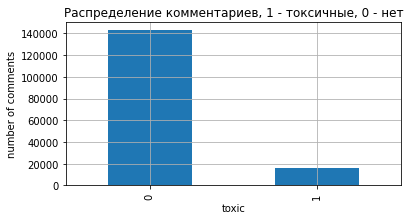

In [11]:
data['toxic'].value_counts().plot(kind='bar', figsize = (6, 3), title = 'Распределение комментариев, 1 - токсичные, 0 - нет', \
                                  xlabel = 'toxic', ylabel = 'number of comments', grid = True);

Примерно 12% комментариев токсичны. Имеет место дисбаланс классов, нужно учитывать это при обучении моделей.

Проверим датасет на полные дубликаты.


In [12]:
data.duplicated().sum()

Дубликатов нет.

Разделим данные на обучающую и тестовую выборки. 

In [13]:
# Разделение датафрейма на признаки и таргет
features = data['lemmatized_text']
target = data['toxic']

# Разделение выборок на обучающие и тестовые
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size = 0.25, 
    stratify=target, 
    random_state = 42
) 

**Выводы по подготовке данных:** 

На этапе подготовки данных

- Перевели столбец 'text' в корпус текстов;
- оставили в датасете только атинские символы и пробелы, убрав лишее функцией clear_text;
- провели лемматизацию текста, привели текст к нижнему регистру;
- проверили текст на дубликаты;
- разделили на тренировочную и тестовую выборки.

## Обучение 

***Создадим таблицу для сравнения результатов обучения несольких моделей.***

In [14]:
df_results = pd.DataFrame(columns=['name_model', 'best_score_', 
                                   'parameters', 'time, c'])

***Создадим функцию, которая добавит результы в таблицу df_results: название модели, лучшая метрика f1, параметры, время обучения модели.***

In [15]:
def model_metrics(name_model, best_score, params, time):
    if name_model not in list(df_results['name_model']):  
        df_results.loc[len(df_results.index )] = \
            [name_model, best_score, params, time]
        
    display(df_results)     

 ***Создадим функцию, которая на вход принимает пайплайн модели, parametrs, название модели, а
  возвращает:***
   - название модели;
   - лучшую метрику f1;
   - лучшие пераметры модели по итогам подбора Randomized_search;
   - время обучения.

In [16]:
def model_creation(pipeline, parametrs, name):
    # Чтобы видеть прогресс выполнения поставим tqdm с разовым циклом:
    for _ in tqdm(range(1)): 
        start = time.time()
        #Применяем RandomizedSearchCV
        randomized_search = RandomizedSearchCV(pipeline, parametrs, scoring='f1', 
                            return_train_score=True)
        randomized_search.fit(features_train, target_train)  
        model_metrics(name, randomized_search.best_score_, 
                      randomized_search.best_params_, time.time() - start)

Поскольку в выборке имеетместо явный дисбаланс классов, будем использовать комплементарный байесовский классификатор (ComplementNB), подходящий для несбалансированных наборов данных. Алгоритм учитывает не только частоту признаков в выборке, но и их отсутствие в других классах, что делает его менее чувствительным к смещению выборки.

***Модель ComplementNB***


In [17]:

pipe_nb = Pipeline([
                    ('vect', TfidfVectorizer(stop_words = list(stopwords))),
                    ('clf', ComplementNB())
])

params_nb = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vect__norm": ("l1", "l2")
}

In [18]:
tqdm.pandas()
model_creation(pipe_nb, params_nb, ComplementNB)

***Модель LogRegression***

In [19]:
pipe_lr = Pipeline([
                    ('vect', TfidfVectorizer(stop_words = list(stopwords))),
                    ('model', LogisticRegression(fit_intercept=True, 
                                random_state = 42,
                                solver='liblinear'))
                  ])

In [20]:
params_lr = {
             'model__C': [0.01, 0.1, 1, 10, 100],
             'model__class_weight': [None, 'balanced']
            }

In [21]:
model_creation(pipe_lr, params_lr, LogisticRegression)

***Модель LGBM Classifier***

In [22]:
pipe_lgbm =  Pipeline([
                    ('vect', TfidfVectorizer()),
                    ('model', LGBMClassifier(
                                            learning_rate = 0.15, 
                                            random_state = 42
                                            ))
                     ])
params_lgbm = {
                   'model__max_depth': [10, 15, 30],
                   'model__n_estimators': [500]
                  }
    

In [23]:
model_creation(pipe_lgbm, params_lgbm, LGBMClassifier)

In [24]:
display(df_results)

**Выводы по этапу обучения:**

***1)*** Создали и обучили модели с использованием RandomizedSearchCV:

- байесовский классификатор для несбалансированных данных ComplementNB;
- LogisticRegression;
- LGBMClassifier.

***2)*** По итогам обучения учшая метрика у модели LightGBM, f1 = 78,6%, но и время обучения у нее в 2 раза дольше (789 секунд), чем у второй по качеству модели LogisticRegression, где метрика f1 равна 77,6%, а время обучения - 396 секунд.

***3)*** Я бы рекомендовала для использования модель LogisticRegression, т к ее метрика проходит критерий заказчика (f1 более 75%), метрика только на 1% уступает метрике лучшей модели, но время обучения LogRegression в два раза меньше, чем у лучшей по метрике LightGBM.

## Тестирование лучшей модели

In [35]:
pipe_lr = Pipeline([
                    ('vect', TfidfVectorizer(stop_words = list(stopwords))),
                    ('model', LogisticRegression(fit_intercept=True, 
                                random_state = 42,
                                solver='liblinear', 
                                class_weight = None,
                                C = 10))
                  ])

In [36]:
best_model = pipe_lr

In [37]:
best_model.fit(features_train, target_train) 
predict_data = best_model.predict(features_test)
f1_score_test = f1_score(target_test, predict_data)
print(f1_score_test)

In [28]:
print(f'F1 лучшей модели на тестовой выборке равна {f1_score_test:.3f}')

Лучшая по соотношению метрики и времени обучения модель LogisticRegression показала на тестовой выборке еще более высокое качество, метрику f1 равную 78,2%.

## Выводы

**1)** Данные загружены. Для экономии времени отрбаотка и тестирование кода проведено на  выборке из 1000 строк.

**2)** Проведена предобработка данных исходного датасета:

- преобразовади столбец 'text' в список текстов;
- убрали лишние символы и пробелмы с помощью функции clear_text:
- создали дополнительный столбец с лемматизированным текстом, привели текст к нижнему регистру;
- выявили дисбаланс классов;
- проверили данные на полные дубликаты;
- разделили данные на обучающую и тестовую выборки в соотношении 3:1.

**3)** Создали пайплайны для трех моделей, включили векторизацию текстов в пайплайн.
Обучили модели с использованием RandomizedSearchCV:
- ComplementNB;
- LogisticRegression;
- LGBMClassifier.

**4)** По итогам сравнения результатов обучения самую высокую метрику выдала модель LGBM, но время обучения этой модели в 2 раза выше (789 секунд), чем у второй, но не сильно уступающей по метрике, модели LogisticRegression. 

**5)** Для тестирования выбрали модель LogisticRegression с оптимальным соотношением метрики (77,6%) и времени обучения (396 секунд). На тестовой выборке модель LogisticRegression показала еще более высокую метрику 78,2%, что проходит критерий заказчика (f1 более 75%). 
Для классифицикации комментариев клиентов на позитивные и негативные рекомендуем заказчику использование модели LogisticRegression.